# Undersampling & individual Gridsearch

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The best parameter is obtained for each classifier using *Gridsearch*. The training data for each classifier is adjusted using *undersampling*. This approach is a combination of the approaches shown in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb) and [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_X_reduced, get_y, get_test_train_data
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition

def get_X():
    return np.vstack([document.text for document in documents])
y = get_y()

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

preprocessing = PreprocessingDefinition('tfidf', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = get_test_train_data(get_X_reduced(preprocessing), y)

preprocessing = PreprocessingDefinition('count', 'basic', 'basic', 'english', '1,1', 'TruncatedSVD')
X_train_count, X_test_count, y_train_count, y_test_count = get_test_train_data(get_X_reduced(preprocessing), y)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec, doc2vec, fasttext2vec

In [4]:
def get_data(embedding):
    if embedding == 'word2vec':
        X_train_, X_test_ = word2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'doc2vec':
        X_train_, X_test_ = doc2vec(X_train, X_test, y)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'fasttext':
        X_train_, X_test_ = fasttext2vec(X_train, X_test)
        return X_train_, X_test_, y_train, y_test
    elif embedding == 'tfidf':
        return X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf
    elif embedding == 'count':
        return X_train_count, X_test_count, y_train_count, y_test_count

In [30]:
paths = available_classifier_paths('classwise')
def create_classifier(classifier_options, name, embedding):
    path = [path for path in paths if name in path.name and embedding in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        preprocessing = PreprocessingDefinition(embedding, 'basic', 'basic', 'english', '1,1', 'None')
        classifier = ClasswiseClassifier(classifier_options, embedding, undersample=True)
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_, y_train_, y_test_ = get_data(embedding)
        clf.fit(X_train_, y_train_)
        clf.score(X_test_, y_test_)
        clf.save('classwise')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods and their specific tuning parameter is found using [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) as in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb).
- Linear SVC, optimizing parameter `C`
- Logistic Regression, optimizing parameter `C`
- MLPClassifier, optimizing parameter `alpha`

[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall#sklearn.metrics.recall_score) is used as  the scoring-function for the optimization. For reasons of that decision see [notebook 3.0](3.0-me-evaluation-metrics.ipynb).

In addition undersampling is used for each individual label as in [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb) Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.

In [6]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'word2vec')

Training: 537.4518582820892s
Test: 2.145263195037842s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015440081461210464     0.03990326481257558      0.3581395881426111       0.30143893591293835      0.2929833997790467       
micro                                                            0.3923007011165931       0.2885450986009645       0.3325171265854128       
macro                                                            0.29952103824877174      0.32490624475707447      0.2501979880680381       


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'word2vec')

Training: 227.99535989761353s
Test: 2.0561695098876953s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014001145548272132     0.05453446191051995      0.38981113606264756      0.3065517936316002       0.3096615711307368       
micro                                                            0.4604918890633176       0.2941316907797355       0.358974358974359        
macro                                                            0.3088181644422469       0.28741947515359945      0.2684192117132096       


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001, 0.001]})]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'word2vec')

Training: 14650.26878118515s
Test: 10.427809238433838s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017321962706039584     0.031076178960096734     0.3850082793734547       0.40571140669085043      0.3569426200562839       
micro                                                            0.3631404381600768       0.3972596199751743       0.3794345645234838       
macro                                                            0.2513141798261965       0.38654081773759896      0.27927845875150525      


**Doc2Vec**

In [18]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'doc2vec')

Training: 4878.969566106796s
Test: 3.231508731842041s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01336345701011901      0.042079806529625154     0.05362075583961921      0.026952841596130588     0.03321592152305575      
micro                                                            0.47818791946308725      0.027212832999140648     0.051495166681723735     
macro                                                            0.11822533784691511      0.02136143274721806      0.026944146451755135     


In [19]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'doc2vec')

Training: 349.3458847999573s
Test: 3.3723459243774414s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01414688474511551      0.04087061668681983      0.0683014431253993       0.04349052801289803      0.047166934530722855     
micro                                                            0.29757021142316187      0.04502052897928005      0.07820858386896122      
macro                                                            0.12092822445686012      0.03633481030665031      0.0435289437665421       


In [20]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001]})]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'doc2vec')

Training: 7868.324965238571s
Test: 9.492684841156006s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.016629542417106853     0.03010882708585248      0.12321739983500944      0.08904675534058847      0.09165972326733741      
micro                                                            0.21064969859343605      0.0900887997708393       0.12620385232744785      
macro                                                            0.09729847205297469      0.06002868350074524      0.06474907866582304      


**FastText**

In [21]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'fasttext')

Training: 511.78052616119385s
Test: 2.19122314453125s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01577101762871508      0.039177750906892385     0.35958932911774505      0.31908101571946795      0.3026684117977951       
micro                                                            0.3848279175926482       0.3058817912727967       0.3408431972336747       
macro                                                            0.3016524130692637       0.36701089999429204      0.27735423836742906      


In [22]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'fasttext')

Training: 231.17536759376526s
Test: 2.1624178886413574s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013337363966142685     0.06094316807738815      0.41484928312316466      0.31893188230552194      0.3256964968391813       
micro                                                            0.49957241701002875      0.3067888857061014       0.38013546688751515      
macro                                                            0.364536148746342        0.30263437004947447      0.3035715064478155       


In [23]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001]})]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'fasttext')

Training: 7961.142310142517s
Test: 10.338266372680664s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01730859797619805      0.031922611850060456     0.39575015459144747      0.4139701733172108       0.36322224396589575      
micro                                                            0.36516975108925415      0.4041344409433782       0.3836653296167879       
macro                                                            0.26387902468947305      0.41651453343730616      0.29511705677446387      


**TFIDF**

In [24]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'tfidf')

Training: 11255.02951335907s
Test: 16.841733932495117s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015695920575319797     0.03857315598548972      0.3993624402602637       0.3769306731156792       0.35523687383421365      
micro                                                            0.40405342684750656      0.3741285455066374       0.38851560756700476      
macro                                                            0.41626250823116523      0.35280704944516744      0.37658914567731383      


In [25]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'tfidf')

Training: 4131.891103982925s
Test: 17.016542673110962s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01334436453891682      0.06408706166868199      0.43341826452467325      0.3241515517936316       0.34272768277000437      
micro                                                            0.49902927120669055      0.3191194728297202       0.3892934117784121       
macro                                                            0.5085773396767427       0.2587266446402432       0.3310208288756048       


In [26]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001]})]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'tfidf')

Training: 37594.0929877758s
Test: 57.679810523986816s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.03399159931267104      0.005078597339782346     0.20856456996188324      0.37876058041112454      0.24125598060439213      
micro                                                            0.16284189321094059      0.3744150510934963       0.22696944697726254      
macro                                                            0.18079568117432637      0.44238114176548343      0.20144233641057877      


**Count**

In [31]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'count')

Training: 14982.073820829391s
Test: 18.052342176437378s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02288296315153058      0.026602176541717048     0.2836137696653905       0.3159169689641273       0.26344734593044156      
micro                                                            0.23468057366362452      0.3187060343589989       0.2703141488757205       
macro                                                            0.25607474109334427      0.28530241779999904      0.2593086648845644       


In [28]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'count')

Training: 4563.2355761528015s
Test: 17.005457401275635s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.018286768917456883     0.03845223700120919      0.30451697503088065      0.2769528415961306       0.260145347169954        
micro                                                            0.29914398482751553      0.27927453701488253      0.28886798990248974      
macro                                                            0.3485908167027853       0.19890584651492832      0.23720555036604302      


In [ ]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE), grid_search=True, parameter={'alpha':[0.0001]})]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'count')

<a id='evaluation'/>

## Evaluation

In [32]:
paths = available_classifier_paths('classwise')
paths = [path for path in paths if 'gridsearch-undersample' in path.name]

In [33]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf) + ' ' + str(clf.preprocessing.vectorizer), evaluation])

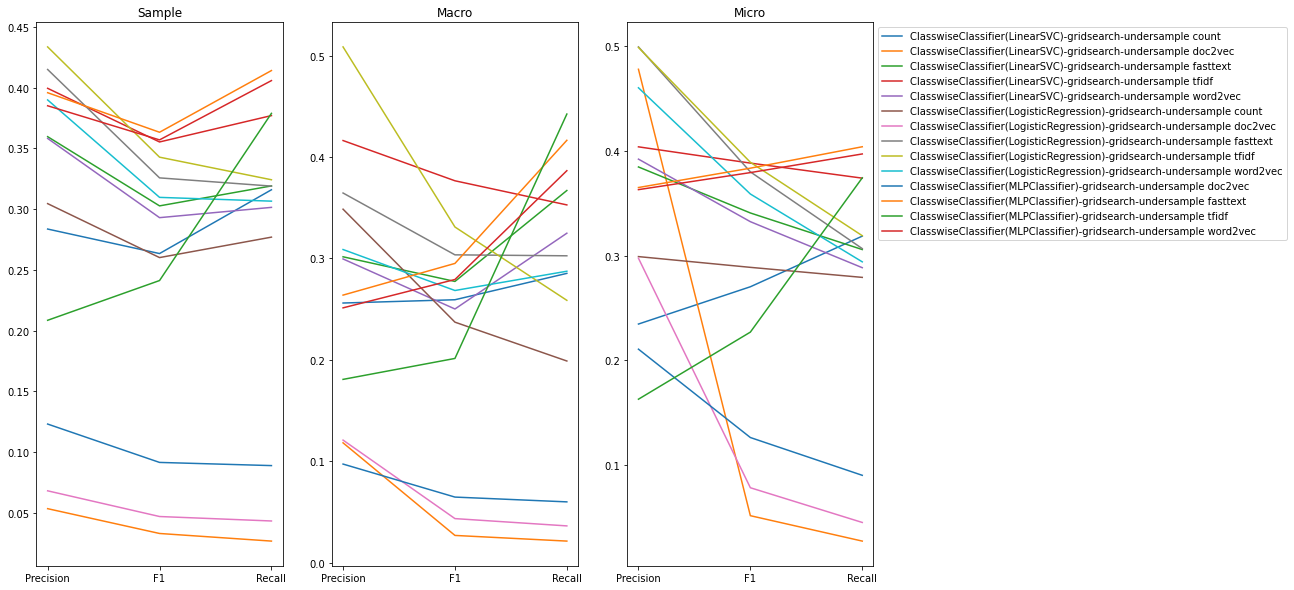

In [34]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [35]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [36]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [37]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    _, X_test_, _, y_test_ = get_data(clf.preprocessing.vectorizer)
    prediction = clf.predict(X_test_)
    label_accuracies = per_label_accuracy(y_test_, prediction)
    report = classification_report(y_test_, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((str(clf) + ' ' + str(clf.preprocessing.vectorizer), classwise_report))

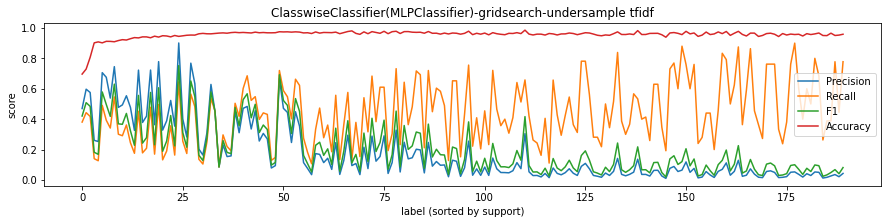

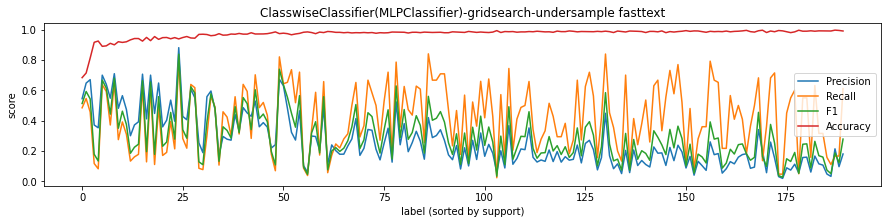

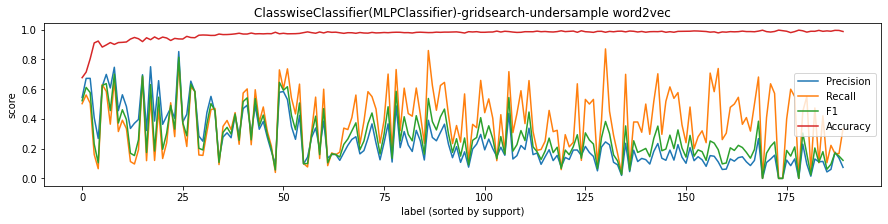

In [38]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()